In [ ]:
!pip install kaggle

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 28.1 MB/s eta 0:00:00


In [ ]:
!ls -l ~/.kaggle/kaggle.json

ls: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c deep-learning-spring-2025-project-2

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
!unzip -oq deep-learning-spring-2025-project-2.zip

In [ ]:
# List the files in the current directory to verify the data is extracted
import os
print("Files in current directory:", os.listdir())

# Check for the existence of test_unlabelled.pkl
if os.path.exists("test_unlabelled.pkl"):
    print("test_unlabelled.pkl found!")
else:
    print("test_unlabelled.pkl not found. Please check if the data has been downloaded and unzipped correctly.")

Files in current directory: ['.config', 'test_unlabelled.pkl', 'deep-learning-spring-2025-project-2.zip', 'sample_data']
test_unlabelled.pkl found!


In [ ]:
# =====================================
# 1. Install Required Libraries
# =====================================
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from transformers import (
    RobertaTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    RobertaForSequenceClassification,
    EarlyStoppingCallback,
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, Dataset
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# =====================================
# 2. Set Device to Use MPS if Available
# =====================================
def get_device():
    # Prefer MPS for macOS, otherwise use CUDA if available; else use CPU.
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define Synonym Augumentation

import nlpaug.augmenter.word as naw

syn_aug = naw.SynonymAug(
    aug_src='wordnet',
    aug_max=5, # max replace num
    aug_p=0.4, # replace probability
)

def duplicate_with_augmentation(batch):
    new_texts = []
    new_labels = []

    for text, label in zip(batch["text"], batch["label"]):
        # original
        new_texts.append(text)
        new_labels.append(label)

        # augmented
        augmented_text = syn_aug.augment(text)
        # If the augmenter returns a list of tokens, join them
        if isinstance(augmented_text, list):
            augmented_text = " ".join(augmented_text)

        new_texts.append(augmented_text)
        new_labels.append(label)

    return {"text": new_texts, "label": new_labels}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# =====================================
# 3. Load the AG News Dataset and Preprocess
# =====================================
from transformers import set_seed

set_seed(42)
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"Number of labels: {num_labels}")
print(f"Class names: {class_names}")

# 1) Split raw vs tokenized pipelines
raw_dataset = load_dataset("ag_news")

# 2) Augment only the train split, then concatenate back with validation/test if needed
raw_train = raw_dataset["train"]

# apply your duplicate_with_augmentation (batched=True)
augmented_train = raw_train.map(
    duplicate_with_augmentation,
    batched=True,
    remove_columns=raw_train.column_names   # we’ll re‐add only the fields we need downstream
)

# 3) Now concatenate the augmented train set back into a new DatasetDict
from datasets import DatasetDict
new_dataset = DatasetDict({
    "train": augmented_train,
    "test":  raw_dataset["test"],
    "validation": raw_dataset["test"],   # or split off a val fold if you had one
})

# 4) Preprocess (tokenize) **all** splits in one shot
def preprocess(examples):
    # tokenization
    tok = tokenizer(examples["text"],
                    truncation=True,
                    padding="max_length",
                    max_length=256)
    # map the old 'label' → 'labels'
    tok["labels"] = examples["label"]
    return tok

tokenized_dataset = new_dataset.map(
    preprocess,
    batched=True,
    remove_columns=["text", "label"]   # drop raw text/label now that we have tokens+labels
)
id2label = {i: label for i, label in enumerate(class_names)}

# 5) Set up collator and everything else
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

Number of labels: 4
Class names: ['World', 'Sports', 'Business', 'Sci/Tech']


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/240000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

# Load the AG News dataset (the training split for inspection)
dataset = load_dataset('ag_news', split='train')

# Print the column names
print("Column names:", dataset.column_names)

# Print the dataset features (schema)
print("\nDataset features:")
print(dataset.features)

# Show a few examples from the dataset
print("\nFirst 5 examples:")
for i in range(5):
    print(f"Example {i}: {dataset[i]}")

Column names: ['text', 'label']

Dataset features:
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}

First 5 examples:
Example 0: {'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
Example 1: {'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}
Example 2: {'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 2}
Example 3: {'text': 'Iraq Halts Oil Exports from Ma

In [ ]:
# =====================================
# 4. Load Pre-trained RoBERTa Model & Apply LoRA
# =====================================
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    num_labels=num_labels
)
model.to(device)
print("Base model loaded and moved to device.")

# Set up LoRA configuration
peft_config = LoraConfig(
    r=11,
    lora_alpha=8,
    lora_dropout=0.07,
    bias="none",
    target_modules=["query", "key"],
    task_type="SEQ_CLS"
)

peft_model = get_peft_model(model, peft_config)
peft_model.to(device)
print("\nPEFT Model with LoRA created. Trainable parameters:")
peft_model.print_trainable_parameters()

trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model loaded and moved to device.

PEFT Model with LoRA created. Trainable parameters:
trainable params: 999,172 || all params: 125,647,880 || trainable%: 0.7952
Total trainable parameters: 999172


In [ ]:
# =====================================
# 5. Create Train and Evaluation Splits
# =====================================
split_datasets = tokenized_dataset['train'].train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Train dataset size: 239360
Eval dataset size: 640


In [ ]:
# =====================================
# 6. Training Setup with Trainer
# =====================================
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=[],
    eval_strategy='steps',
    logging_steps=500,
    learning_rate=1e-4,
    num_train_epochs=2,
    #max_steps=1200,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    # lr_scheduler_type="cosine",
    warmup_steps=1000,
    weight_decay=0.001,
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant': True}
)

def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator
    )

trainer = get_trainer(peft_model)

print("\nStarting training...")
train_result = trainer.train()
print("Training complete.")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Starting training...


Step,Training Loss,Validation Loss,Accuracy
500,1.226600,0.424353,0.871875
1000,0.337900,0.282447,0.900000
1500,0.301500,0.276275,0.904687
2000,0.316300,0.255780,0.900000
2500,0.284600,0.247029,0.912500
3000,0.259400,0.244033,0.909375
3500,0.269800,0.253397,0.903125
4000,0.251000,0.233751,0.917188
4500,0.257100,0.235917,0.914062
5000,0.254300,0.218382,0.915625


Training complete.


In [ ]:
# =====================================
# 7. Evaluate the Model
# =====================================
print("\nEvaluating on validation set...")
eval_metrics = trainer.evaluate()
print(f"Evaluation metrics: {eval_metrics}")


Evaluating on validation set...


Evaluation metrics: {'eval_loss': 0.17327171564102173, 'eval_accuracy': 0.940625, 'eval_runtime': 2.0619, 'eval_samples_per_second': 310.394, 'eval_steps_per_second': 4.85, 'epoch': 2.0}


In [ ]:
def preprocess_infer(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

In [ ]:
# =====================================
# 8. Inference on Unlabeled Test Data
# =====================================
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    from torch.utils.data import DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    current_device = get_device()
    inference_model.to(current_device)
    inference_model.eval()
    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')
    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(current_device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        preds = outputs.logits.argmax(dim=-1).cpu()
        all_predictions.append(preds)
        if labelled:
            references = batch["labels"].cpu()
            metric.add_batch(
                predictions=preds.numpy(),
                references=references.numpy()
            )
    all_predictions = torch.cat(all_predictions, dim=0)
    if labelled:
        eval_metric = metric.compute()
        return eval_metric, all_predictions
    return all_predictions

_, _ = evaluate_model(peft_model, eval_dataset, labelled=True, batch_size=8, data_collator=data_collator)

# -------------------------------------
# Inference on Unlabelled Test Data
# -------------------------------------
print("\nRunning inference on test_unlabelled.pkl...")
unlabelled_obj = pd.read_pickle("/content/test_unlabelled.pkl")
print("Type of unlabelled_obj:", type(unlabelled_obj))

if isinstance(unlabelled_obj, pd.DataFrame):
    unlabelled_dataset = Dataset.from_pandas(unlabelled_obj)
else:
    unlabelled_dataset = unlabelled_obj

# Apply tokenization preprocessing
test_dataset = unlabelled_dataset.map(preprocess_infer, batched=True,  remove_columns=["text"])

# Run inference (without expecting labels)
preds = evaluate_model(peft_model, test_dataset, labelled=False, batch_size=8, data_collator=data_collator)

df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()
})

submission_file = os.path.join(output_dir, "inference_output.csv")
df_output.to_csv(submission_file, index=False)
print(f"Inference complete. Predictions saved to {submission_file}")

100%|██████████| 80/80 [00:02<00:00, 31.55it/s]



Running inference on test_unlabelled.pkl...
Type of unlabelled_obj: <class 'datasets.arrow_dataset.Dataset'>


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:30<00:00, 32.99it/s]

Inference complete. Predictions saved to results/inference_output.csv


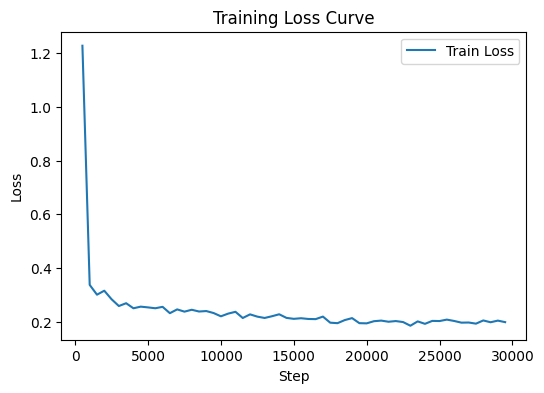

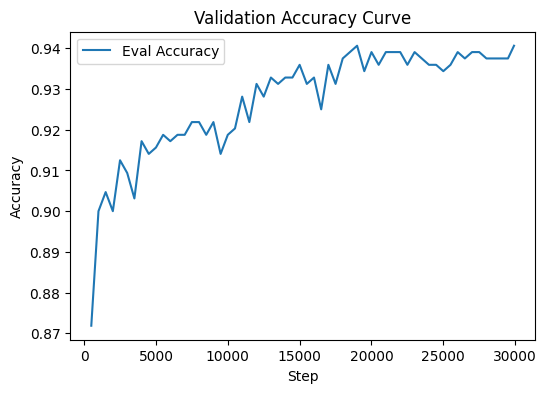

In [ ]:
import matplotlib.pyplot as plt

# 1) Pull out logs from trainer
logs = trainer.state.log_history

# 2) Extract lists of steps, train_loss, and eval_accuracy
train_steps, train_losses = [], []
eval_steps, eval_accuracies = [], []

for record in logs:
    if record.get("loss") is not None and record.get("step") is not None:
        # training loss entries
        train_steps.append(record["step"])
        train_losses.append(record["loss"])
    if record.get("eval_accuracy") is not None:
        # eval accuracy entries
        eval_steps.append(record["step"])
        eval_accuracies.append(record["eval_accuracy"])

# 3) Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(train_steps, train_losses, label="Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# 4) Plot accuracy curve
plt.figure(figsize=(6,4))
plt.plot(eval_steps, eval_accuracies, label="Eval Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()
